In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
import matplotlib

django.db.connection.close()


In [2]:
pid = 178
qid = 8145
qid = 8272
q = Query.objects.get(pk=qid)
qs = Query.objects.filter(pk__in=[8145,7368,8272])
p = Project.objects.get(pk=pid)

print(q.doc_set.count())

379897


In [3]:
ar5_docs = Doc.objects.filter(query=6956, content__iregex="\w").exclude(
    pk__in=[
        1461495, # Espinoza 2013
        1626875, # White, 2007
        1622783, # Why is Oliveira, 2007 included?
        1627593, # Killeen 2008
        1627701, # Also, Nepstad and Stickler, 2008
        2093363, # Etter
        2090005, # Nepstad, 2006
        1627734, # Polidoro 2010
        2089982, # Mars, 2007
        2090013, # Randolph 2010
        2093360, # Petney 2012
        2089960, # Wassenaar, 2007 - LUC
        1627733, # Polidoro 2010, very weak - not main conclusion
        2090004, # Veran 2007 - long line fishing
        2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
        2089944, # Jellyman - eels
        2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
        2089959, # Bruno, 2007 
        1514856, # de Waroux 2012
        2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
        2089950
    ]
)

ar5_ids = set(ar5_docs.values_list('pk',flat=True))

ar5_docs.count()

256

In [4]:
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qs, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf['ar5'] = 0
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

# Ar5 docs
ar5_df = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=ar5_ids).values('id')
)
ar5_df['ar5'] = 1
ar5_df['seen'] = 1
ar5_df['relevant'] = 1
ar5_df.head()

seen_df = pd.concat([ar5_df,gdf])
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)
print(seen_df.shape)
seen_df.head()


(2489, 8)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant
0,374765,Soil respiration (R-s) is the second-largest t...,A cross-biome synthesis of soil respiration an...,apparent Q(10); aridity index; drought; meta-a...,[Biodiversity Conservation; Ecology; Environme...,0,1.0,0.0
1,770076,Climate is well known as an important determin...,Present-day and future contribution of climate...,boreal forests; China; climate change; dynamic...,[Ecology],0,1.0,1.0
2,471951,Many of the largest wildfires in US history bu...,Medieval warming initiated exceptionally large...,wildfire; climate change; Medieval Climate Ano...,[Multidisciplinary Sciences],0,1.0,1.0
3,552782,Recent hydro-climatological trends and variabi...,Characterisation of hydroclimatological trends...,Bayesian change point; trend detection; Double...,[Water Resources],0,1.0,1.0
4,772497,Temperature variability is a major driver of e...,Community responses to seawater warming are co...,assemblage composition; benthic invertebrates;...,[Biology; Ecology; Evolutionary Biology],0,1.0,0.0


In [5]:
predicted_relevance = pd.read_csv('../data/doctables/all_relevance.csv')
predicted_ids = predicted_relevance.query('upper_pred>0.5')
print(predicted_ids.shape)

(82368, 12)


In [6]:
#predicted_ids = pd.read_csv('../data/doctables/predicted_relevant_ids.csv')

unseen_docs = q.doc_set.filter(
    content__iregex='\w',
    pk__in=predicted_ids['id']
).exclude(pk__in=seen_df['id']).distinct('id')

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(82343, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,26,Physical and chemical limnological variables w...,Physical and chemical limnological characteris...,warming climate; high-latitude lakes; polar li...,[Limnology; Marine & Freshwater Biology],0,0
1,48,Using outgoing longwave radiation (OLR) and Tr...,The influence of Amazon rainfall on the Atlant...,None,[Meteorology & Atmospheric Sciences],0,0
2,111,1 .Gradients in elevation are increasingly use...,Changes in host-parasitoid food web structure ...,climate change; elevation; experimental manipu...,[Ecology; Zoology],0,0
3,160,Comparison of glacially derived clastic inputs...,Late-Holocene NAO and oceanic forcing on high-...,AMO; ITRAX; late Holocene; NAO; proglacial lak...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
4,168,While the loss of structural complexity causes...,The effect of coral morphology on shelter sele...,Reef fish; Structural complexity; Coral reef; ...,[Marine & Freshwater Biology],0,0


In [7]:
django.db.connection.close()
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_tag = Tag.objects.get(query__project=p,title="random sample 1")
r_index = df[(df['id'].isin(r_tag.doc_set.values_list('pk',flat=True))) & (df['seen']==1)].index
print(df.shape)
df.head()

(84832, 8)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant
0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,[Ecology],NaN,0.0,0.0
1,3316697,Survival of enchytraeids from three areas was ...,Survival of frost and drought conditions in th...,enchytraeidae; alpine; arctic; drought; gut co...,[Ecology; Soil Science],NaN,0.0,0.0
2,1344198,The effect of the El Nino - Southern Oscillati...,Winter rainfall in Iran: ENSO and aloft wind i...,Iran; ENSO; aloft wind; winter rainfall,[Multidisciplinary Sciences],NaN,0.0,0.0
3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"[Engineering, Civil; Geosciences, Multidiscipl...",NaN,0.0,0.0
4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,[Ecology; Environmental Sciences],NaN,0.0,0.0


## Get AR5 categories

In [8]:
cats = Category.objects.filter(project=p,level=12)
early_ids = set(DocOwnership.objects.filter(
    query__in=qs,tag__lt=4765
).values_list('doc__pk',flat=True))
ldf = pd.DataFrame.from_dict(list(Doc.objects.filter(pk__in=set(ar5_ids)|early_ids).filter(
    category__in=cats
).values('id','category__level','category__name')))
ldf['cname'] =  ldf['category__level'].astype(str) + " - " + ldf['category__name']
ldf = ldf.drop(columns=['category__level','category__name'])
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="cname", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)

## Get majority category decision

In [9]:
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=seen_df['id'],category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
print(dudf_wide.shape)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()
dudf_wide_r = dudf_wide.reset_index()
dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).head()
print(gudf.shape)
gudf.tail()

(1580, 231)
(1205, 232)


cname,doc__id,10 - places,11 - Africa,11 - Asia,11 - Australasia,11 - Central & South America,11 - Europe,11 - Global,11 - North America,11 - Open ocean,...,8 - 8.03. Quantitative - process-based modelling,8 - 8.04. Quantitative - empirical models,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations
1200,3322609,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1201,3322812,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1202,3322939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1203,3322946,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1204,3324870,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
print(df.shape)
df.head()

(84832, 239)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,12 - Human and managed,...,8 - 8.03. Quantitative - process-based modelling,8 - 8.04. Quantitative - empirical models,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations
0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,[Ecology],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3316697,Survival of enchytraeids from three areas was ...,Survival of frost and drought conditions in th...,enchytraeidae; alpine; arctic; drought; gut co...,[Ecology; Soil Science],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1344198,The effect of the El Nino - Southern Oscillati...,Winter rainfall in Iran: ENSO and aloft wind i...,Iran; ENSO; aloft wind; winter rainfall,[Multidisciplinary Sciences],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"[Engineering, Civil; Geosciences, Multidiscipl...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,[Ecology; Environmental Sciences],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
physical_tags = Tag.objects.filter(query__in=qs,id__gt=5177)
pdos = DocOwnership.objects.filter(tag__in=physical_tags,relevant__gt=0).values_list('doc__id',flat=True)
physical_index = df[(df['id'].isin(list(pdos))) & (df['relevant']==1)].index
len(physical_index)

831

In [12]:
df['ca_rated'] = 0
df.loc[physical_index,'ca_rated'] = 1

In [13]:
django.db.connection.close()

In [14]:
Category.objects.filter(project=p,level=12,name__iregex='\w').exclude(name__in=["not included in table"]).values('id','name')

<QuerySet [{'id': 710, 'name': 'Physical systems'}, {'id': 321, 'name': 'Rivers, lakes, and soil moisture'}, {'id': 323, 'name': 'Coastal and marine Ecosystems'}, {'id': 322, 'name': 'Terrestrial ES'}, {'id': 320, 'name': 'Mountains, snow and ice'}, {'id': 324, 'name': 'Human and managed'}]>

In [15]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
all_classes = []
i = 0
broad_cats = []
for c in cats:
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname in df.columns and df[ecname].sum()>=5:
            all_classes.append(ecname)
            i+=1
    bc["end"] = i
    bc["size"] = i-bc["start"]
    broad_cats.append(bc)
            
print(len(all_classes))
broad_cats

49


[{'end': 10, 'name': 'Physical systems', 'size': 10, 'start': 0},
 {'end': 14, 'name': 'Mountains, snow and ice', 'size': 4, 'start': 10},
 {'end': 22,
  'name': 'Rivers, lakes, and soil moisture',
  'size': 8,
  'start': 14},
 {'end': 29, 'name': 'Coastal and marine Ecosystems', 'size': 7, 'start': 22},
 {'end': 38, 'name': 'Terrestrial ES', 'size': 9, 'start': 29},
 {'end': 49, 'name': 'Human and managed', 'size': 11, 'start': 38}]

12 - Physical systems
0
155


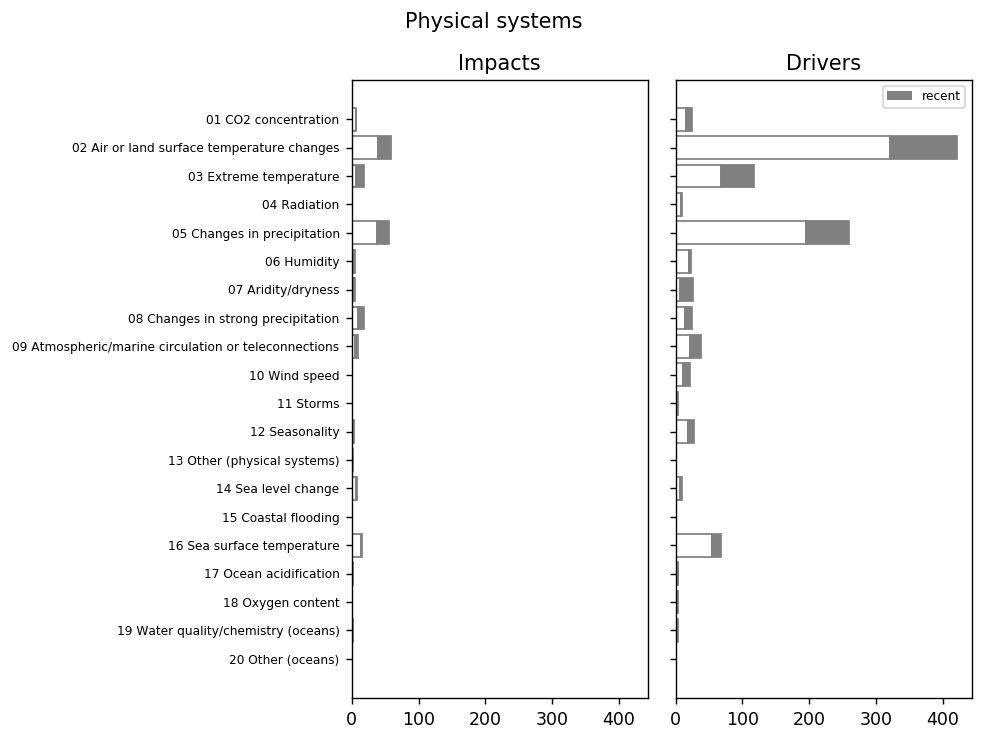

12 - Mountains, snow and ice
83.0
154.0


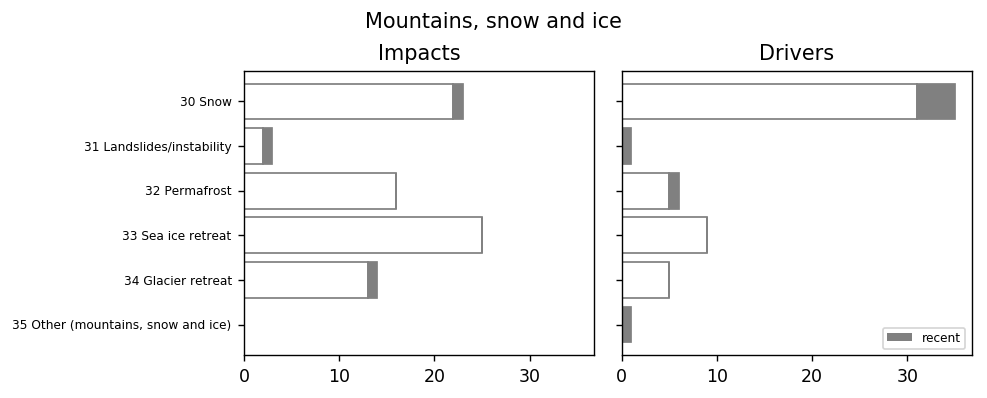

12 - Rivers, lakes, and soil moisture
103.0
304.0


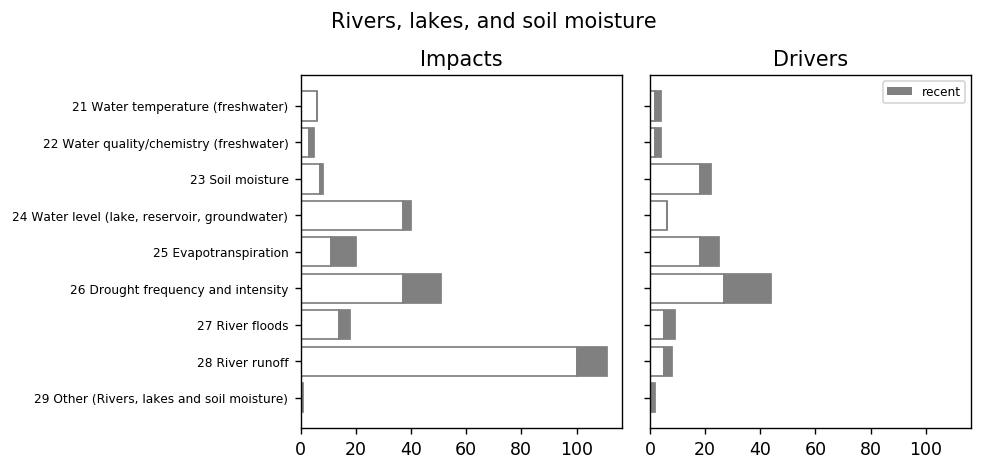

12 - Coastal and marine Ecosystems
101.0
181.0


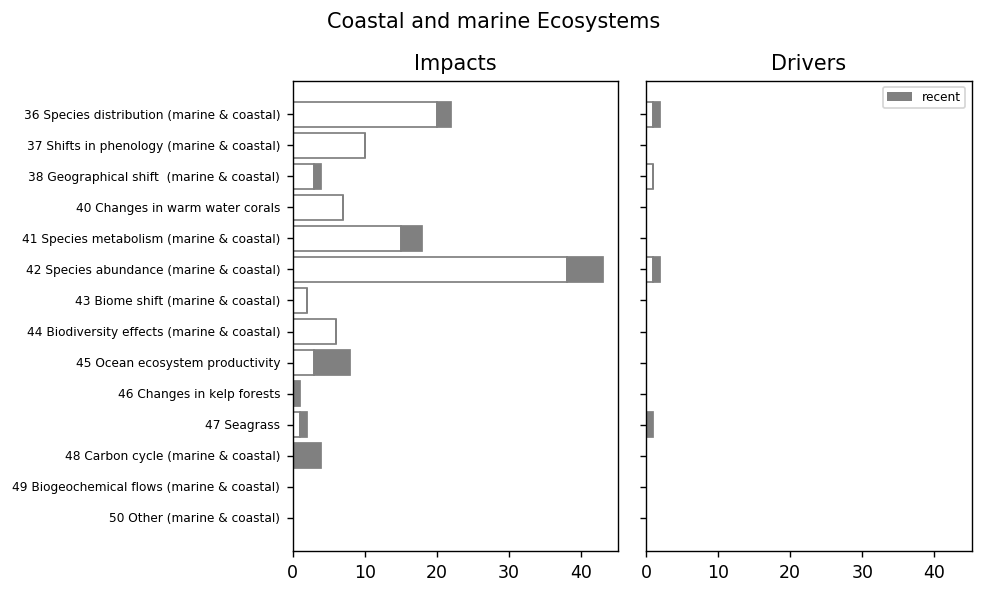

12 - Terrestrial ES
121.0
488.0


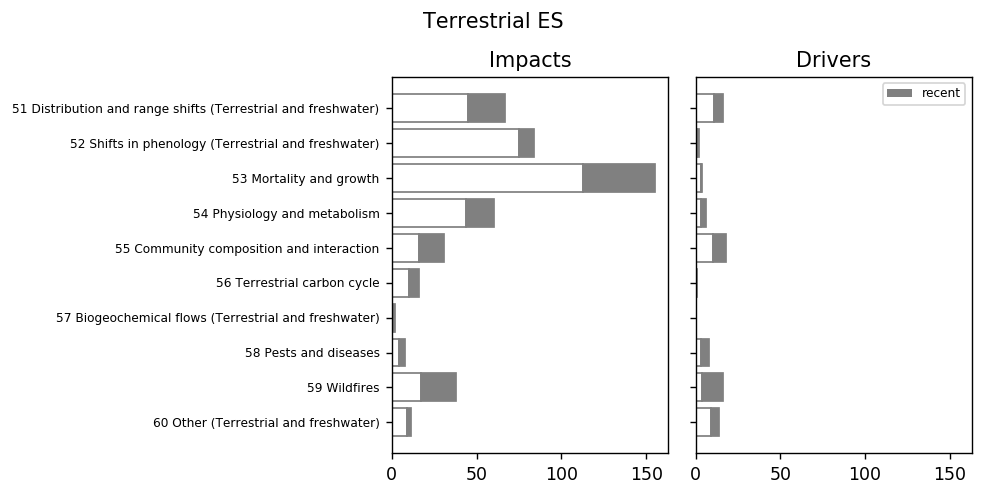

12 - Human and managed
54.0
261.0


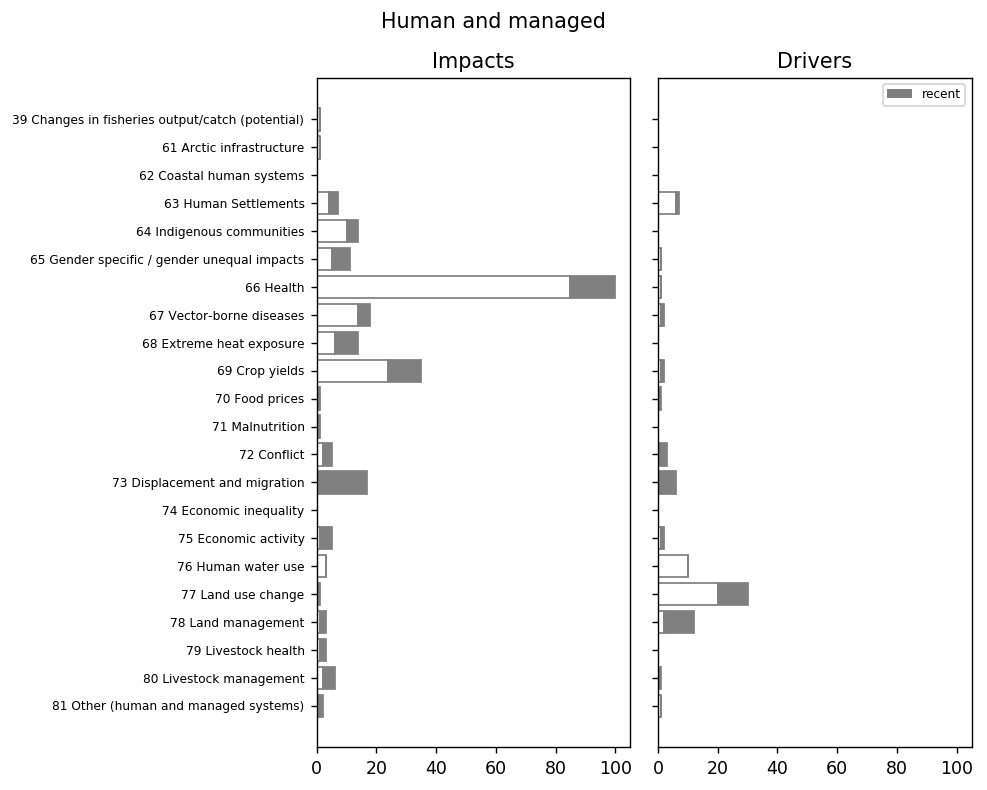

In [16]:

django.db.connection.close()
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
cats
classes = []


recent_tag_ids = list(Tag.objects.filter(query__project=p,id__gt=5361).values_list('doc__id',flat=True))

for c in cats:
    cname = f"{c.level} - {c.name}"
    print(cname)
    if cname in df.columns:
        pass
        print(df[cname].sum())
    else:
        df[cname] = 0
        print(0)
        
    fig, axs = plt.subplots(1,2,dpi=125,figsize=(8,2+0.2*c.equivalents.exclude(name__icontains='<hidden>').count()/2),sharey=True,sharex=True)
    ticks = []
    i = -1
    for ec in c.equivalents.all().order_by('-name','level'):
        ecname = f"{ec.level} - {ec.name}"

        
        if "<hidden>" not in ec.name:
            if ec.level==4:
                i+=1
                ticks.append(ec.name)
        
        if ecname in df.columns:
            if ec.level==4:
                df.loc[df[ecname]==1,cname] = 1  
            if "<hidden>" not in ec.name:
                if ec.level==4:
                    axs[0].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[0].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                else:
                    axs[1].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[1].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                
    if df[cname].sum()>0:
        if cname != "12 - Physical systems":
            classes.append(cname)
    print(df[cname].sum())
    
    axs[0].set_title("Impacts")
    axs[1].set_title("Drivers")
    
    axs[0].set_yticks(range(len(ticks)))
    axs[0].set_yticklabels(ticks,fontsize=7)
    
    axs[1].barh([0],[0],label="recent",color="grey")
    axs[1].legend(fontsize=7)
    
    plt.suptitle(c.name)
    fig.tight_layout()
    plt.subplots_adjust(top=0.81+0.002*c.equivalents.exclude(name__icontains='<hidden>').count())
    
    plt.savefig(f'../plots/progress/cats_labels_{c.name.replace(" ","_")}.pdf',bbox_inches="tight")
    
    plt.show()

In [17]:
import_df = False
if import_df:
    df = pd.read_csv(f'../data/all_categories.csv')
    seen_index = df[df['seen']==1].index
    unseen_index = df[df['seen']==0].index
    new_index = df[(df['seen']==1) & (df['ar5']==0)].index
    rel_index = df[df['relevant']==1].index
    r_tag = Tag.objects.get(query__project=p,title="random sample 1")
    r_index = df[(df['id'].isin(r_tag.doc_set.values_list('pk',flat=True))) & (df['seen']==1)].index
    
print(df.shape)

(84832, 241)


In [18]:
df.to_csv(f'../data/all_categories.csv')

In [173]:
df.loc[df['title']=="CLIMATE CHANGE AND ITS IMPACT ON THE HYDROLOGICAL PROCESSES OF THE TALAS RIVER IN CENTRAL ASIA","12 - Rivers, lakes, and soil moisture"] = 1

In [7]:
revectorize = False
retransform = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer(),
        #sublinear_tf=True
    )
    vec.fit(df.loc[seen_index,'content'].astype("str"))

    X = vec.transform(df['content'].astype("str"))#+" " + df['title'].astype("str"))   
    with open (f'../data/vec_{q.id}_prel.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{q.id}_prel.npz', X)
else:
    with open (f'../data/vec_{q.id}_prel.pickle','rb') as f:
        vec = pickle.load(f)
        if retransform:
            X = vec.transform(df['content'].astype("str"))
            scipy.sparse.save_npz(f'../data/X_{q.id}_prel.npz', X)
        else:
            X = scipy.sparse.load_npz(f'../data/X_{q.id}_prel.npz')
            
print(X.shape)

(84825, 19349)


In [175]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[all_classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_impacts, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=all_classes, df = df)

(84825, 49)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in lab

6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/softwar

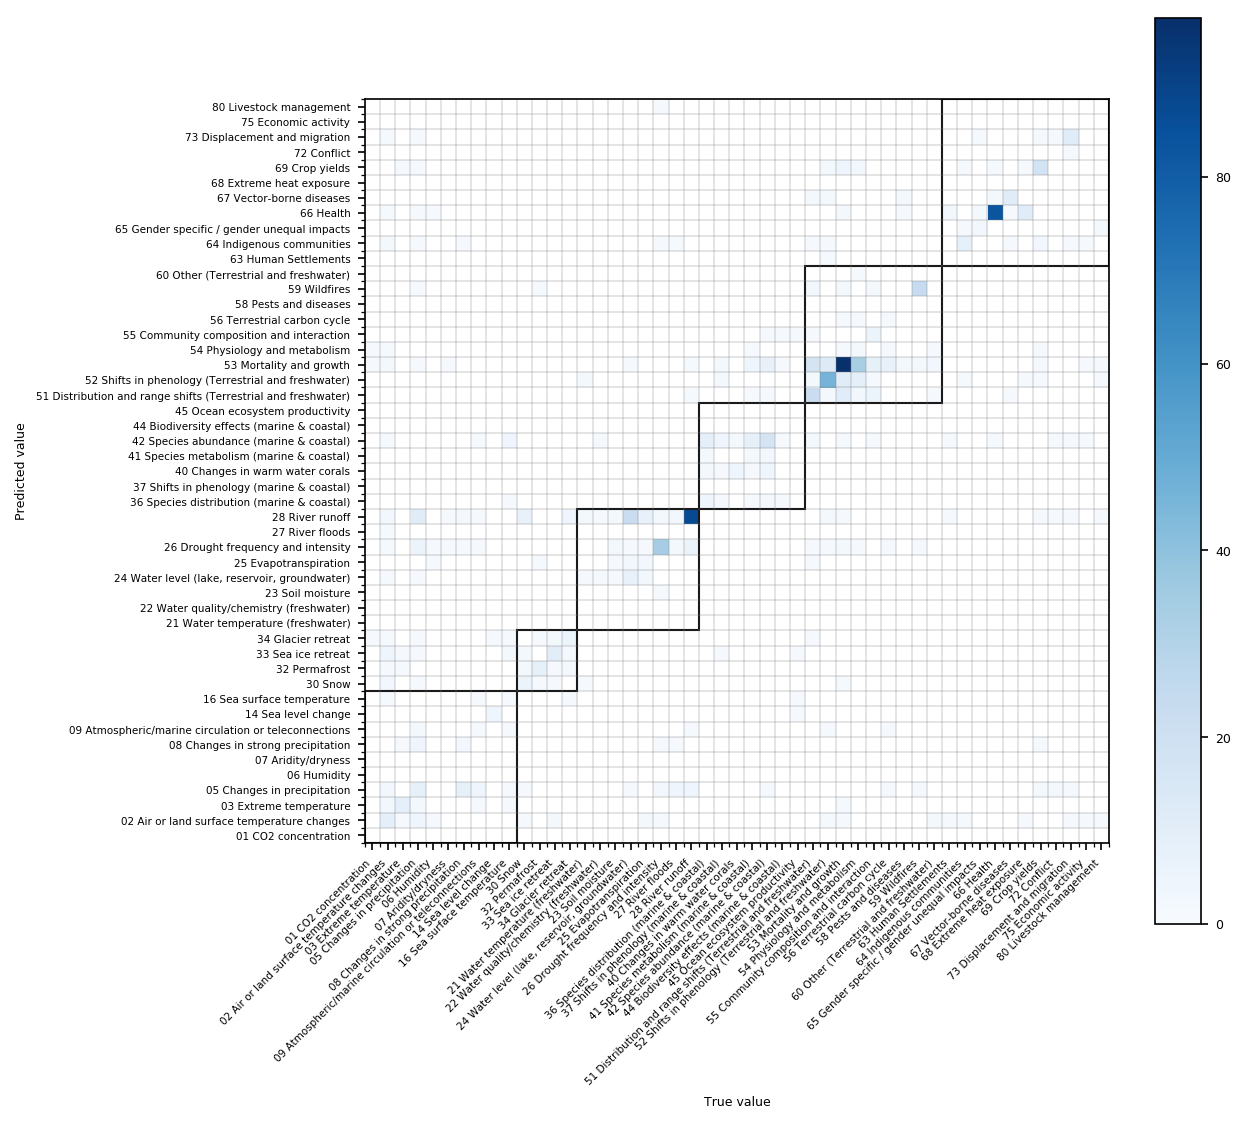

In [176]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

cols = [f"{c} - k_prediction_binary" for c in all_classes]
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols),len(cols)),dtype=float)

for j, c in enumerate(all_classes):
    for k, c in enumerate(all_classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n


def plot_confusion_matrix(cm, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[j,k]
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color)

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_xlabel("True value", fontsize=6)
    ax.set_ylabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax)
    cbar.ax.tick_params(labelsize=6)
    if norm ==0:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    
plot_confusion_matrix(confusion_matrix,broad_cats=broad_cats)

plt.savefig(f'../plots/prediction_models/confusion_all_classes.pdf',bbox_inches="tight")


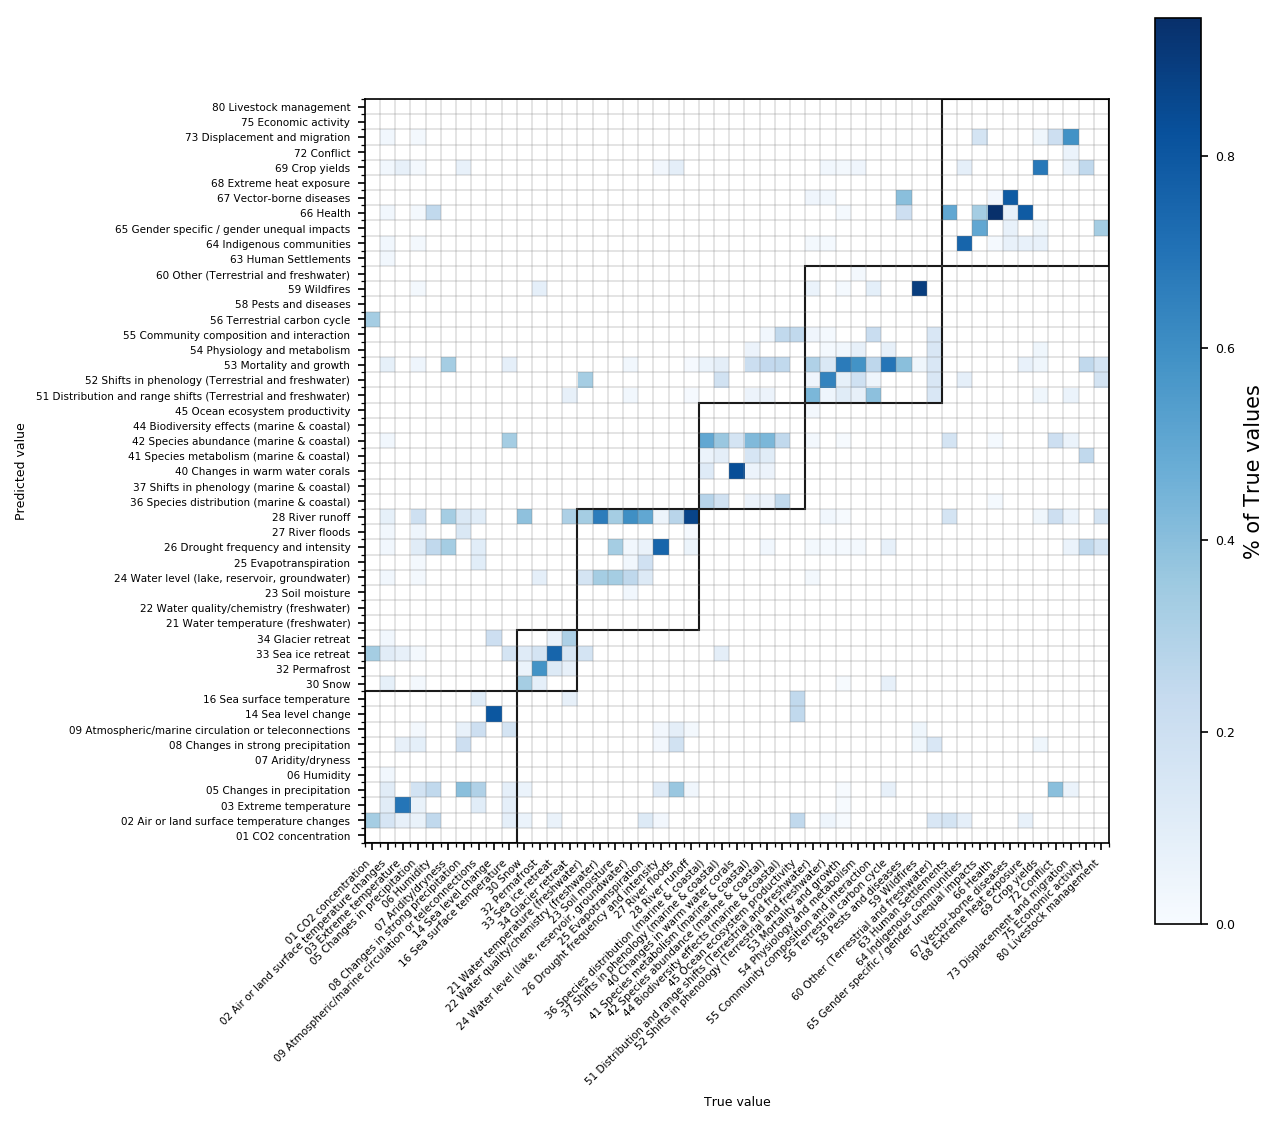

In [80]:
fig, ax = plt.subplots(figsize=(8,8),dpi=150)
plot_confusion_matrix(confusion_matrix,norm=0,broad_cats=broad_cats)
plt.savefig(f'../plots/prediction_models/confusion_all_classes_pred.pdf',bbox_inches="tight")

In [177]:
kf = KFold(n_splits=6)
kfs = kf.split(X[physical_index],y[physical_index])
y_preds = []
for k_train, k_test in kfs:
    clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    k_train = physical_index[k_train]
    clf.fit(X[k_train],y[k_train])
    y_preds.append(clf.predict(X[unseen_index]))

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))


KeyboardInterrupt: 

In [178]:
len(y_preds)

5

In [111]:
y = np.matrix(df[all_classes])
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[physical_index],y[physical_index])
y_pred = clf.predict_proba(X[unseen_index])


In [112]:
y_pred_binary = clf.predict(X[unseen_index])

In [118]:
y_pred_binary[:,0].shape

(68484,)

In [120]:
for i, c in enumerate(all_classes):
    df.loc[unseen_index, f"{c} - prediction"] = y_pred_binary[:,i]

In [114]:
y_pred_binary.shape

(68484, 49)

In [18]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    #{
    #    'title': 'One vs rest SVC', 
    #    'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    #},
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df = df)


(84825, 5)
1
2
3
4
5
6


In [12]:
y.shape

(84825, 5)

In [21]:
kf = KFold(n_splits=6)
kfs = kf.split(X[physical_index],y[physical_index])
y_preds = []
i = 0
for k_train, k_test in kfs:
    i+=1
    print(i)
    clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    k_train = physical_index[k_train]
    clf.fit(X[k_train],y[k_train])
    y_preds.append(clf.predict(X[unseen_index]))

1
2
3
4
5
6


In [33]:
i = 0
np.array(y_preds)[:,:,i].shape

for i, c in enumerate(classes):
    mean_pred = np.mean(np.array(y_preds)[:,:,i], axis=0)
    std_pred = np.std(np.array(y_preds)[:,:,i], axis=0)
    preds_upper = np.minimum(mean_pred + std_pred, 1)
    preds_lower = np.maximum(mean_pred - std_pred, 0)


    df.loc[unseen_index,f'{c} - mean_prediction'] = mean_pred
    df.loc[unseen_index,f'{c} - std_prediction'] = std_pred
    df.loc[unseen_index,f'{c} - lower_pred'] = preds_lower
    df.loc[unseen_index,f'{c} - upper_pred'] = preds_upper

In [34]:
df.to_csv('../data/category_predictions_cats.csv',index=False)

In [36]:
[c for c in df.columns if 'mean_prediction' in c] 

['12 - Mountains, snow and ice - mean_prediction',
 '12 - Rivers, lakes, and soil moisture - mean_prediction',
 '12 - Coastal and marine Ecosystems - mean_prediction',
 '12 - Terrestrial ES - mean_prediction',
 '12 - Human and managed - mean_prediction']

In [130]:
y = np.matrix(df[classes])
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[physical_index],y[physical_index])
y_pred = clf.predict(X[unseen_index])
for i, c in enumerate(classes):
    df.loc[unseen_index, f"{c} - prediction"] = y_pred[:,i]

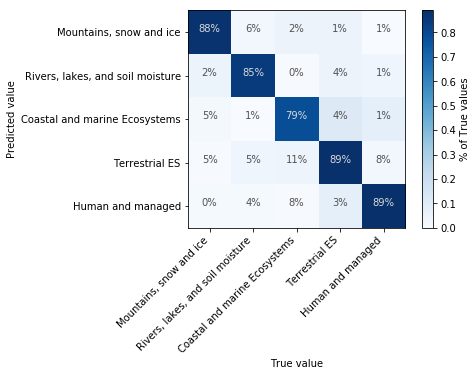

In [19]:
cols = [f"{c} - k_prediction_binary" for c in classes]
y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1,keepdims=True)

fig, ax = plt.subplots()

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

plt.savefig(f'../plots/prediction_models/category_confusion.pdf',bbox_inches="tight")


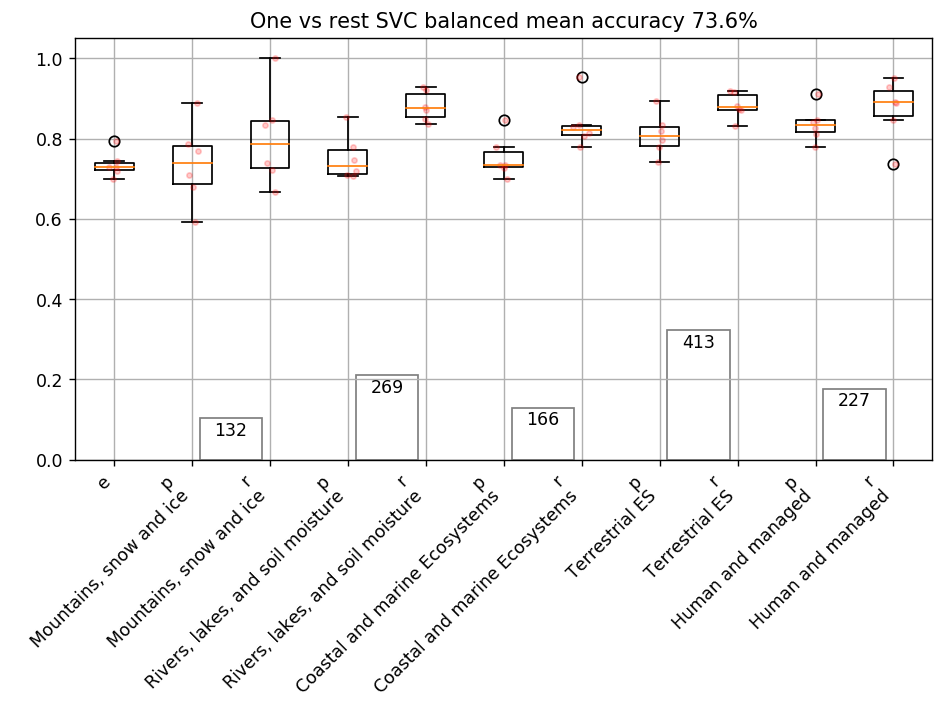

In [123]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_ar5, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(10,7),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
    
pmetrics = [m for m in metrics if m!="e"]
lu.plot_model_output(multimodels_ar5, pmetrics , fig, axs)
ax = axs[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.text(i+.5,max([.22,s+0.03]), c.replace('12 - ','').replace('and','\nand'),va="bottom",ha="center",bbox=props)
            ax.bar(i+.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.split('\n')[0] for x in pmetrics],rotation=0,ha="center")
ax.grid(False,axis="x")
ax.grid(True,which="minor",axis="x")
ax.set_xticks([i+.5 for i,x in enumerate(pmetrics) if i%2==0],minor=True)
ax.set_ylabel('Precision (p), Recall (r), proportion of labels (bar)')
fig.tight_layout()
plt.savefig(f'../plots/progress/cats_prediction.pdf',bbox_inches="tight")
plt.show()

In [87]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]

keys = ['p','r','f1','e','auc']

for i, s in enumerate([0.1,0.2,0.4,0.6,0.8,1]):
    s_index = rel_index[:round(len(rel_index)*s)]
    multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, s_index, n_splits=6, classes=classes, df = df)
    if i==0:
        mdf = pd.DataFrame.from_dict({ key: multimodels_ar5[0][key] for key in keys })
        mdf['sample'] = s
        mdfs = mdf
    else:
        mdf = pd.DataFrame.from_dict({ key: multimodels_ar5[0][key] for key in keys })
        mdf['sample'] = s
        mdfs = pd.concat([mdfs,mdf])
        

(15673, 5)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
3
4
5
6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
4
5
6


(36, 6)


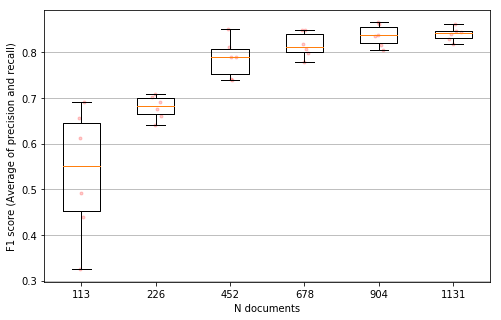

In [140]:
print(mdfs.shape)
fig,ax = plt.subplots(figsize=(8,5))
mdfs.head()
boxes = []
labels = []
for i, (name, group) in enumerate(mdfs.groupby('sample')):
    ys = group['f1'].values
    boxes.append(ys)
    x = np.random.normal(i+1, 0.04, size=len(ys))
    ax.plot(x, ys, 'r.', alpha=0.2)
    labels.append(int(name*len(rel_index)))
    
ax.boxplot(boxes)
ax.set_xticklabels(labels)

ax.set_xlabel('N documents')
ax.set_ylabel('F1 score (Average of precision and recall)')
ax.grid(axis="y")

plt.savefig(f'../plots/progress/cats_prediction_n.pdf')


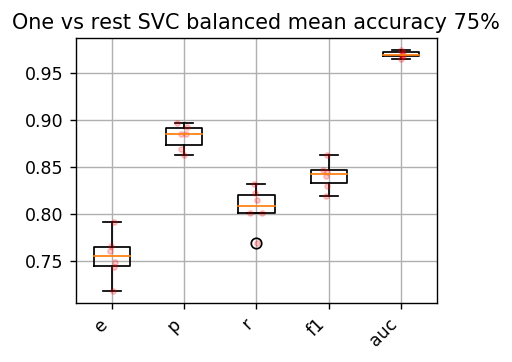

In [21]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(4,3),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_ar5, ['e','p','r','f1','auc'], fig, axs)
ax.set_xticklabels([x for x in metrics], rotation=45, ha="right")
plt.show()

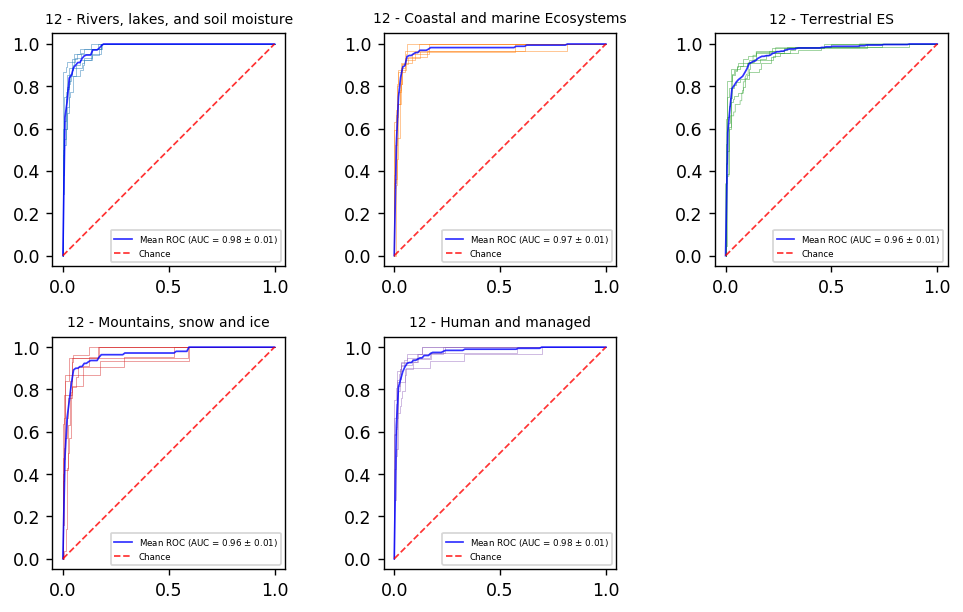

In [22]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_ar5:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()

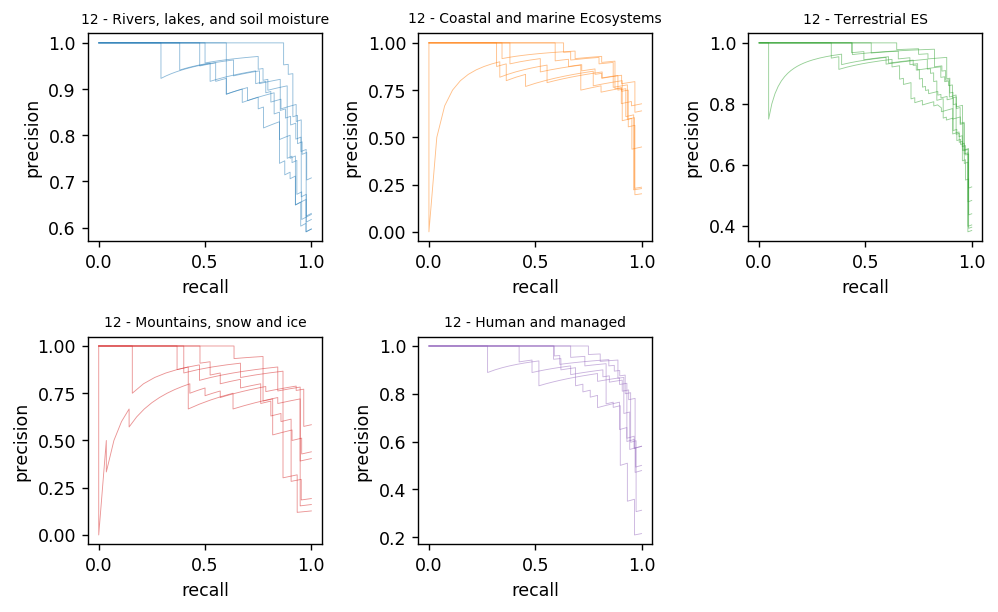

In [23]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_ar5:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'rec\n{c}'][i],
                model[f'prec\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
        ax.set_ylabel('precision')
        ax.set_xlabel('recall')
        ax.set_title(c,fontsize=8)
        
fig.tight_layout()

In [24]:
df[df['title']=="Increasing ocean temperatures allow tropical fishes to survive overwinter in temperate waters"]

,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,12 - Human and managed,...,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations,12 - Physical systems,"12 - Rivers, lakes, and soil moisture - k_prediction",12 - Coastal and marine Ecosystems - k_prediction,12 - Terrestrial ES - k_prediction,"12 - Mountains, snow and ice - k_prediction",12 - Human and managed - k_prediction
12541,593733,The southeast coast of Australia is a global h...,Increasing ocean temperatures allow tropical f...,butterflyfish; coral reef fish; damselfish; oc...,[Biodiversity Conservation; Ecology; Environme...,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN


In [25]:
d = Doc.objects.get(tslug=Doc.make_tslug("Increasing ocean temperatures allow tropical fishes to survive overwinter in temperate waters"))
d.docownership_set.all().values('user__username','relevant')

<QuerySet [{'user__username': 'nicole.vanmaanen@climateanalytics.org', 'relevant': 2}]>

In [26]:
django.db.connection.close()
c = "12 - Coastal and marine Ecosystems"
#c = "12 - Mountains, snow and ice"
c = "12 - Rivers, lakes, and soil moisture"
fp = df[(df[c]==0) & (df[f'{c} - k_prediction']>0.5)]
print(fp.shape)
for i, row in fp.sort_values(f'{c} - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[4,6]).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

(29, 227)
Daily Precipitation Changes over Large River Basins in China, 1960-2013
Based on a high-quality dataset of 713 daily precipitation series, changes in daily precipitation events during 1960-2013 were observed in China's ten largest river basins. Specifically, the amount of precipitation in four categories defined by fixed thresholds and their proportion on total precipitation were analyzed on annual and seasonal time scales. Results showed annual precipitation increased by 1.10 mm/10yr in China, but with obvious spatial differences. Regionally, annual precipitation increased significantly in northwestern rivers, upstream areas of the Yangtze River, the Yellow River, southwestern rivers (due to increase in light and moderate precipitation); and in southeastern rivers, downstream areas of the Yangtze River, and the Pearl River (due to increase in heavy and extreme precipitation). Annual precipitation decreased significantly in the mid-Yangtze River and upstream Pearl River (due 

In [27]:
#c = "12 - Coastal and marine Ecosystems"
#c = "12 - Mountains, snow and ice"
fn = df[(df[c]==1) & (df[f'{c} - k_prediction']<0.5)]
print(fn.shape)
for i, row in fn.head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(row[c])
    print(d.docusercat_set.values('category__name'))
    for c in df.columns:
        if "k_prediction" in c:
            print(c)
            print(row[c])

(39, 227)
Detection and attribution of twentieth-century northern and southern African rainfall change
The spatial patterns, time history, and seasonality of African rainfall trends since 1950 are found to be deducible from the atmosphere's response to the known variations of global sea surface temperatures (SSTs). The robustness of the oceanic impact is confirmed through the diagnosis of 80 separate 50-yr climate simulations across a suite of atmospheric general circulation models. Drying over the Sahel during boreal summer is shown to be a response to warming of the South Atlantic relative to North Atlantic SST, with the ensuing anomalous interhemispheric SST contrast favoring a more southern position of the Atlantic intertropical convergence zone. Southern African drying during austral summer is shown to be a response to Indian Ocean warming, with enhanced atmospheric convection over those warm waters driving subsidence drying over Africa. The ensemble of greenhouse-gas-forced exper

In [28]:
cat = Category.objects.get(name='25 Glacier retreat',level=4)
d = Doc.objects.get(tslug=Doc.make_tslug("Impact of Climate Change on Vegetation Growth in Arid Northwest of China from 1982 to 2011"))
u = User.objects.get(username="marina.andrijevic@climateanalytics.org")
duc, created = DocUserCat.objects.get_or_create(doc=d,category=cat,user=u)
print(duc,created)

DocUserCat object (92472) False


In [ ]:
teams = {
    "12 - Physical systems": {
        "members":[
            "jean-david.coulibaly@climateanalytics.org",
            "kaylin.lee@climateanalytics.org",
            "shruti.nath@climateanalytics.org",
            "peter.pfleiderer@climateanalytics.org"
        ]
    },
    "12 - Rivers, lakes, and soil moisture": {
        "members" : [
            "chelsea.jones@climateanalytics.org",
            "agathe.lucas@climateanalytics.org",
            "quentin.lejeune@climateanalytics.org",
        ]
    },
    "12 - Coastal and marine Ecosystems": {
        "members" : [
            "nicole.vanmaanen@climateanalytics.org",
            "carl.schleussner@climateanalytics.org",
            #"alex.nauels@climateanalytics.org"
        ]
    },
    "12 - Terrestrial ES": {
        "members" : [
            "burcu.yesil@climateanalytics.org",
            "robert.brecha@climateanalytics.org",
            "gerrithansen@mailbox.org"
        ]
    },
    "12 - Mountains, snow and ice": {
        "members" : [
            "marina.andrijevic@climateanalytics.org",
            "inga.menke@climateanalytics.org"
        ]
    },
    "12 - Human and managed": {
        "members" : [
            "michael.hegarty@climateanalytics.org",
            "emily.theokritoff@climateanalytics.org",
        ]
    }

}

In [136]:
y = np.matrix(df[classes])
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[rel_index],y[rel_index])
y_pred = clf.predict_proba(X[unseen_index])


['12 - Rivers, lakes, and soil moisture',
 '12 - Coastal and marine Ecosystems',
 '12 - Terrestrial ES',
 '12 - Mountains, snow and ice',
 '12 - Human and managed']

12 - Rivers, lakes, and soil moisture
2469
12 - Coastal and marine Ecosystems
1345
12 - Terrestrial ES
4374
12 - Mountains, snow and ice
316
12 - Human and managed
1046


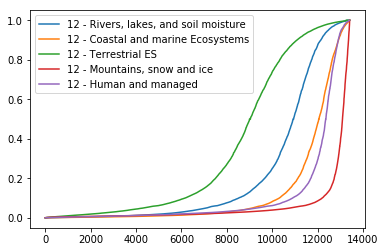

,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,12 - Human and managed,...,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations,12 - Physical systems,"12 - Rivers, lakes, and soil moisture - prediction",12 - Coastal and marine Ecosystems - prediction,12 - Terrestrial ES - prediction,"12 - Mountains, snow and ice - prediction",12 - Human and managed - prediction
0,1375196,This paper provides a detailed description of ...,Relationships between spring snow mass and sum...,0,[Meteorology & Atmospheric Sciences],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.056253,0.003454,0.102661,0.184402,0.041294
1,1900274,The link between El Nino-southern oscillation ...,Decadal changes in the link between El Nino an...,El Nino; NAO; Europe-North Africa; precipitati...,[Meteorology & Atmospheric Sciences],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.071151,0.005194,0.058398,0.010442,0.019538
2,168908,Changes in hydro-meteorological historical rec...,Hydro-meteorological trends in semi-arid north...,trend detection; variability; climate change; ...,[Water Resources],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
3,799658,Effective monitoring of drought plays an impor...,Effect of Air Temperature on Historical Trend ...,Drought; Temperature; SPI; SPEI; Trend; Divers...,"[Engineering, Civil; Water Resources]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.940554,0.003185,0.027934,0.023125,0.025179
4,1469889,Daily streamflow from stations close to five S...,Effect of glaciers on streamflow trends in the...,0,[Environmental Sciences; Limnology; Water Reso...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.855762,0.000829,0.002798,0.854170,0.003372


In [137]:
fig, ax = plt.subplots()
for i,c in enumerate(classes):
    df.loc[unseen_index,f"{c} - prediction"] = y_pred[:,i]
    print(c)
    print(np.where(y_pred[:,i]>0.5)[0].shape[0])
    ax.plot(np.sort(y_pred[:,i]),label=c)

ax.legend()
plt.show()
df.to_csv('../data/category_predictions.csv',index=False)
df.head()

In [ ]:
undone_dos = DocOwnership.objects.filter(query__project=p,relevant=0)
for do in undone_dos:
    if DocOwnership.objects.filter(doc=do.doc, query__project=p, relevant__gt=0).exists():
        pass
        #print(do.user, do.tag)
        #do.delete()

In [ ]:
django.db.connection.close()
add_docs = False
now = datetime.datetime.now()
q = Query.objects.get(pk=8272)
for i,c in enumerate(classes):
    t = teams[c]
    print(c)
    for m in t['members']:
        try:
            u = User.objects.get(username=m)
        except:
            print("could not find user", m)
            
    if c=="12 - Physical systems":
        continue
        cdf = df.loc[unseen_index[np.argwhere(y_pred.max(axis=1)<0.5)[:,0]]]
    else:
        cdf = df.loc[unseen_index[np.argwhere(y_pred[:,i]>0.4)[:,0]]]
    print(cdf.shape[0])
    for j, r in cdf.head().iterrows():
        print(r['title'])
        
    cdf.to_csv(f'../data/latest_predicted_{c}')
    print()

    if add_docs:
        tag = Tag(
            title=f"predicted {c} sample {now}",
            query=q
        )
        tag.save()
        for m in t['members']:
            u = User.objects.get(username=m)
            not_done_dos = DocOwnership.objects.filter(query__project=p,user=u,tag__pk__gt=5247,relevant=0)
            if not_done_dos.count() > 5:
                print(f"continuing due to existing commitments for user: {u.username} - {not_done_dos.count()}")
                continue
            else:
                print(f"assigning {c} docs to {u.username}")
            max_docs = 50
            docs_added = 0
            for i, row in cdf.sample(frac=1).reset_index(drop=True).iterrows():
                d = Doc.objects.get(id=row['id'])
                if d.docownership_set.filter(query=q).exists():
                    continue
                else:
                    
                    if docs_added < max_docs:
                        d.tag.add(tag)
                        do, created = DocOwnership.objects.get_or_create(
                            doc=d,
                            query=q,
                            tag=tag,
                            user=u
                        )
                        docs_added+=1
                    else:
                        break  
        



        tag.update_tag()
        if not tag.docownership_set.exists():
            tag.delete()

## Predict physical systems

In [ ]:
y = df['12 - Physical systems']

now = datetime.datetime.now()
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models = lu.cross_validate_models(X, y, clf_models, physical_index)

In [ ]:
fig, axs = plt.subplots(1, 3,dpi=125,figsize=(8,6),sharey=False,sharex=True)              
lu.plot_model_output(clf_models,['p','r','e'], fig, axs)
plt.show()

In [ ]:
django.db.connection.close()
impact_cats = Category.objects.filter(project=p,level=3,name__iregex='\w')
impact_cats

# Attribution

In [37]:
attribution_classes =  [
 #'2 - 2.2 Trend attribution',
 '2 - Trend or climate change attribtion',
 '2 - 2.4. Sensitivity',
 '2 - 2.5. Detection of a regional climate trend (no attribution)'
]

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from importlib import reload  
reload(scoping.utils.learning_utils)

df['2 - Trend or climate change attribtion'] = 0
 
df.loc[(df['2 - 2.2 Trend attribution']==1) | (df['2 - 2.1. Climate change attribution']==1),'2 - Trend or climate change attribtion'] = 1
y = np.matrix(df[attribution_classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]


y.sum(axis=0)


attribution_models, attribution_metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=attribution_classes, df =df)


(84825, 3)
1
2
3
4
5
6


e
p
2 - Trend or climate change attribtion
r
2 - Trend or climate change attribtion
p
2 - 2.4. Sensitivity
r
2 - 2.4. Sensitivity
p
2 - 2.5. Detection of a regional climate trend (no attribution)
r
2 - 2.5. Detection of a regional climate trend (no attribution)


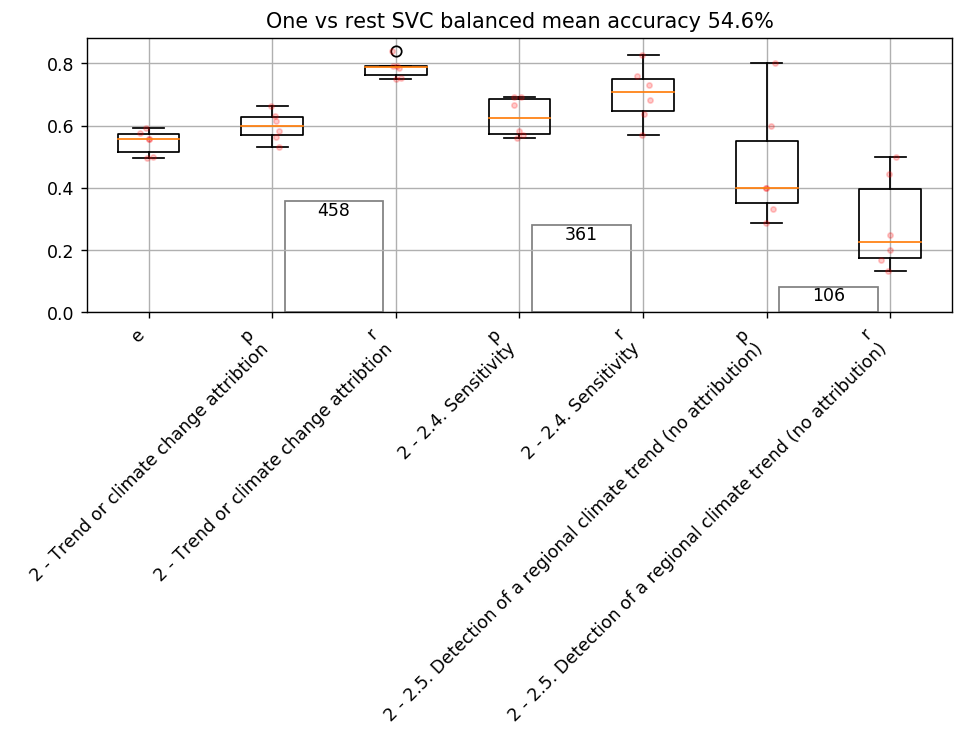

In [38]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(attribution_models, attribution_metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(attribution_metrics):
    print(m)
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x for x in attribution_metrics], rotation=45, ha="right")
plt.show()

In [127]:
y = np.matrix(df[attribution_classes])
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[physical_index],y[physical_index])
y_pred = clf.predict(X[unseen_index])
for i, c in enumerate(attribution_classes):
    df.loc[unseen_index, f"{c} - prediction"] = y_pred[:,i]

In [39]:
y

matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [40]:
y = np.matrix(df[attribution_classes])
kf = KFold(n_splits=6)
kfs = kf.split(X[physical_index],y[physical_index])
y_preds = []
i = 0
for k_train, k_test in kfs:
    i+=1
    print(i)
    clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    k_train = physical_index[k_train]
    clf.fit(X[k_train],y[k_train])
    y_preds.append(clf.predict(X[unseen_index]))

1
2
3
4
5
6


In [41]:
i = 0
np.array(y_preds)[:,:,i].shape

for i, c in enumerate(attribution_classes):
    mean_pred = np.mean(np.array(y_preds)[:,:,i], axis=0)
    std_pred = np.std(np.array(y_preds)[:,:,i], axis=0)
    preds_upper = np.minimum(mean_pred + std_pred, 1)
    preds_lower = np.maximum(mean_pred - std_pred, 0)


    df.loc[unseen_index,f'{c} - mean_prediction'] = mean_pred
    df.loc[unseen_index,f'{c} - std_prediction'] = std_pred
    df.loc[unseen_index,f'{c} - lower_pred'] = preds_lower
    df.loc[unseen_index,f'{c} - upper_pred'] = preds_upper

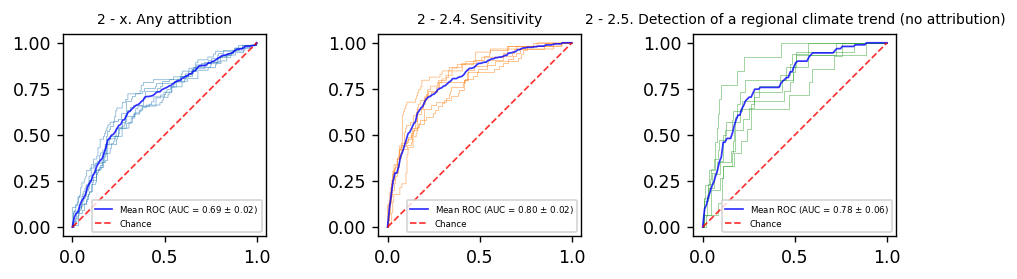

In [154]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in attribution_models:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()

['12 - Mountains, snow and ice', '12 - Rivers, lakes, and soil moisture', '12 - Coastal and marine Ecosystems', '12 - Terrestrial ES', '12 - Human and managed']
['2 - Trend or climate change attribtion - k_prediction_binary', '2 - 2.4. Sensitivity - k_prediction_binary', '2 - 2.5. Detection of a regional climate trend (no attribution) - k_prediction_binary']


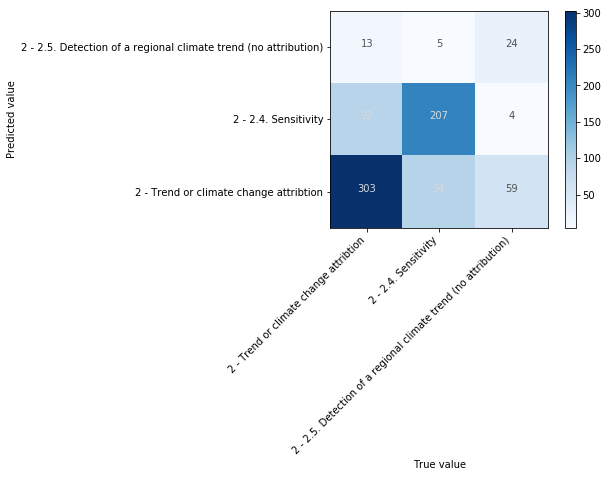

In [59]:
print(classes)

cols = [f"{c} - k_prediction_binary" for c in attribution_classes]
print(cols)
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(attribution_classes),len(attribution_classes)),dtype=int)

for j, c in enumerate(attribution_classes):
    for k, c in enumerate(attribution_classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,j]+y_true[i,j]!=2:
                    n+=1
        confusion_matrix[j,k]=n

#confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0, keepdims=True)

fig, ax = plt.subplots()

mat = ax.imshow(confusion_matrix, cmap="Blues", origin="lower")
for j, c in enumerate(attribution_classes):
    for k, c in enumerate(attribution_classes):
        n  = confusion_matrix[j,k]
        if n > confusion_matrix.mean():
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(k,j, f"{confusion_matrix[j,k]}",ha="center",color=color)
        
ax.set_xticks(list(range(len(attribution_classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in attribution_classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(attribution_classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in attribution_classes],ha="right")
ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)


plt.savefig(f'../plots/prediction_models/confusion_attribution.pdf',bbox_inches="tight")

In [58]:
confusion_matrix

89.0

## All attribution

In [ ]:
django.db.connection.close()
cats = Category.objects.filter(project=p,level=2,name__iregex='\w').exclude(name__icontains="<hidden>")
cats
classes = []
ticks = []
plt.close()
fig, ax = plt.subplots(dpi=125,figsize=(5,6),sharey=True,sharex=True)

for i, c in enumerate(cats.order_by('name')):
    cname = f"{c.level} - {c.name}"
    print(cname)
    if cname in df.columns:
        pass
        print(df[cname].sum())
    else:
        df[cname] = 0
        print(0)   
    
    ticks.append(cname)

    ax.barh(i, df[cname].sum(),color="none",edgecolor="grey",linewidth=1)            
    if df[cname].sum()>50:
        if cname != "12 - Physical systems":
            classes.append(cname)
    print(df[cname].sum())
    
ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks,fontsize=7)
    
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from importlib import reload  
reload(scoping.utils.learning_utils)

print(classes)

y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
attribution_models_all, attribution_metrics, df = lu.cross_validate_models(X, y, multimodels, physical_index, n_splits=6, classes=classes, df =df)

e
p
2 - 2.1. Climate change attribution
r
2 - 2.1. Climate change attribution
p
2 - 2.2 Trend attribution
r
2 - 2.2 Trend attribution
p
2 - 2.4. Sensitivity
r
2 - 2.4. Sensitivity
p
2 - 2.5. Detection of a regional climate trend (no attribution)
r
2 - 2.5. Detection of a regional climate trend (no attribution)


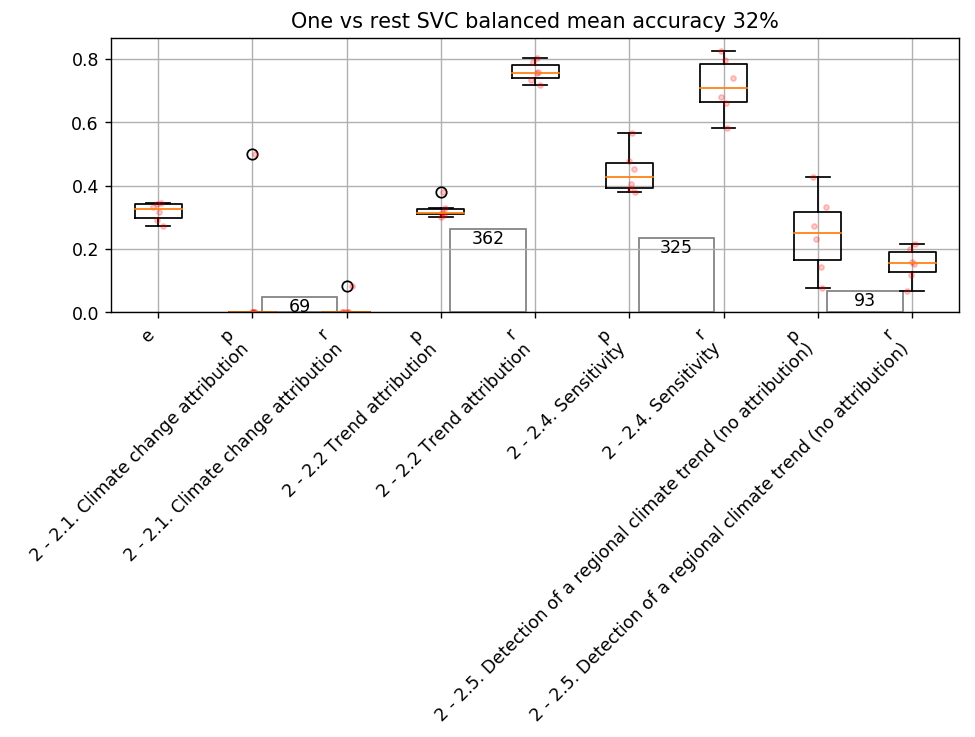

In [141]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(attribution_models_all, attribution_metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(attribution_metrics):
    print(m)
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(physical_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x for x in attribution_metrics], rotation=45, ha="right")
plt.show()

['2 - 2.1. Climate change attribution', '2 - 2.2 Trend attribution', '2 - 2.4. Sensitivity', '2 - 2.5. Detection of a regional climate trend (no attribution)']
['2 - 2.1. Climate change attribution - k_prediction_binary', '2 - 2.2 Trend attribution - k_prediction_binary', '2 - 2.4. Sensitivity - k_prediction_binary', '2 - 2.5. Detection of a regional climate trend (no attribution) - k_prediction_binary']


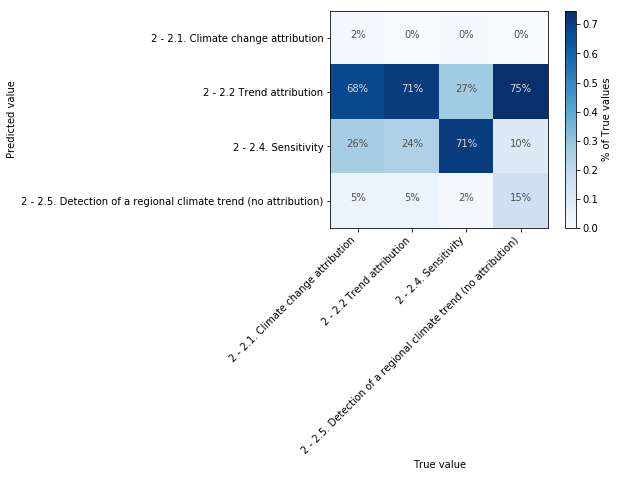

In [149]:
print(classes)

cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,j]+y_true[i,j]!=2:
                    n+=1
        confusion_matrix[j,k]=n

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0)

fig, ax = plt.subplots()

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

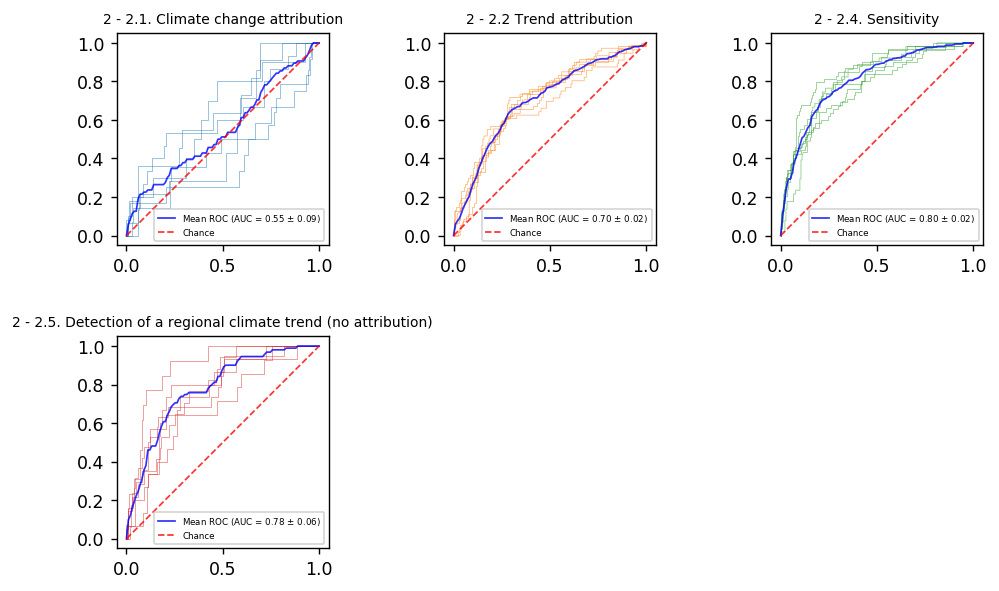

In [150]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in attribution_models_all:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()

In [148]:
confusion_matrix

array([[0.01538462, 0.00258398, 0.0030581 , 0.        ],
       [0.67692308, 0.71059432, 0.27217125, 0.74725275],
       [0.26153846, 0.24031008, 0.70948012, 0.0989011 ],
       [0.04615385, 0.04651163, 0.01529052, 0.15384615]])

In [ ]:
django.db.connection.close()
c = "12 - Coastal and marine Ecosystems"
#c = "12 - Mountains, snow and ice"
c = "2 - 2.1. Climate change attribution"
fp = df[(df[c]==0) & (df[f'{c} - k_prediction']>0.5)]
print(fp.shape)
for i, row in fp.sort_values(f'{c} - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[4,6]).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

In [ ]:
fn = df[(df[c]==1) & (df[f'{c} - k_prediction']<0.5)]
print(fn.shape)
for i, row in fn.sort_values(f'{c} - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[2]).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

In [ ]:
tp = df[(df[c]==1) & (df[f'{c} - k_prediction']>0.0)]
print(tp.shape)
for i, row in tp.sort_values(f'{c} - k_prediction',ascending=True).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print(row['title'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[2]).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col and "2 - 2" in col:
            print(col)
            print(row[col])

# Climate change attribution only

In [ ]:
y = df['2 - 2.1. Climate change attribution']

from importlib import reload  
reload(scoping.utils.learning_utils)

now = datetime.datetime.now()
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models = lu.cross_validate_models(X, y, clf_models, physical_index, n_splits=6)

In [ ]:
fig, axs = plt.subplots(1, 3,dpi=125,figsize=(8,6),sharey=False,sharex=True)              
lu.plot_model_output(clf_models,['p','r','e'], fig, axs)
plt.show()

In [ ]:
clf = SVC(kernel='linear',class_weight='balanced',probability=True)

clf.fit(X[physical_index],y[physical_index])
y_pred = clf.predict_proba(X[unseen_index])
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

p_rel_index = df[df['prediction']>0.5].index

plt.show()

In [ ]:
df.sort_values('prediction',ascending=False)

In [ ]:
django.db.connection.close()
tagged_docs = set(Doc.objects.filter(tag__query__in=qs).values_list('pk',flat=True))
len(tagged_docs)
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

newtag = False

if newtag:
    tag = Tag(
        title="predicted ca attribution sample {}".format(now),
        query=q
    )
    tag.save()

    max_docs = 20
    docs_added = 0
    prel = True
    for i, row in df.sort_values('prediction',ascending=False).reset_index(drop=True).iterrows():
        if row['id'] in tagged_docs:
            continue
        d = Doc.objects.get(id=row['id'])
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False


    tag.update_tag()

In [43]:
[(c,df[c].sum()) for c in df.columns if " - mean" in c]

[('12 - Mountains, snow and ice - mean_prediction', 1994.0),
 ('12 - Rivers, lakes, and soil moisture - mean_prediction',
  7694.166666666668),
 ('12 - Coastal and marine Ecosystems - mean_prediction', 3508.5),
 ('12 - Terrestrial ES - mean_prediction', 28089.166666666668),
 ('12 - Human and managed - mean_prediction', 6168.333333333334),
 ('2 - Trend or climate change attribtion - mean_prediction', 37018.0),
 ('2 - 2.4. Sensitivity - mean_prediction', 26211.0),
 ('2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction',
  1869.0000000000002)]

In [44]:
df.to_csv('../data/category_predictions.csv',index=False)